<a href="https://colab.research.google.com/github/ChengyuWang1007/Compressive-Holography/blob/main/distortion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imaging through distortion
## David Brady
## University of Arizona
## December 2020

The initial goal of this notebook is to train a neural network to focus defocused coherent images. This is part of a larger project to look at imaging through turbulence.


## initialization

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]


## problem definition

we consider imaging a remote object with coherent light. The basic system geometry is shown below.

--2021-01-03 23:19:29--  https://docs.google.com/uc?export=download&confirm=&id=1LDQizYPN6YRJE5SQsNXSQWhADsjUaQba
Resolving docs.google.com (docs.google.com)... 108.177.12.102, 108.177.12.139, 108.177.12.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.12.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/itdriofu2araa4gg7e1o0u9ah5u6esct/mg7ltl0kkukd2p6716dckbqobh43i7h6/1609715925000/09386012468922455624/07537122996411398124Z/1LDQizYPN6YRJE5SQsNXSQWhADsjUaQba?e=download [following]
--2021-01-03 23:19:29--  https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/itdriofu2araa4gg7e1o0u9ah5u6esct/mg7ltl0kkukd2p6716dckbqobh43i7h6/1609715925000/09386012468922455624/07537122996411398124Z/1LDQizYPN6YRJE5SQsNXSQWhADsjUaQba?e=download
Resolving doc-0k-a0-docs.googleusercontent.com (doc-0k-a0-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to 

(-0.5, 674.5, 225.5, -0.5)

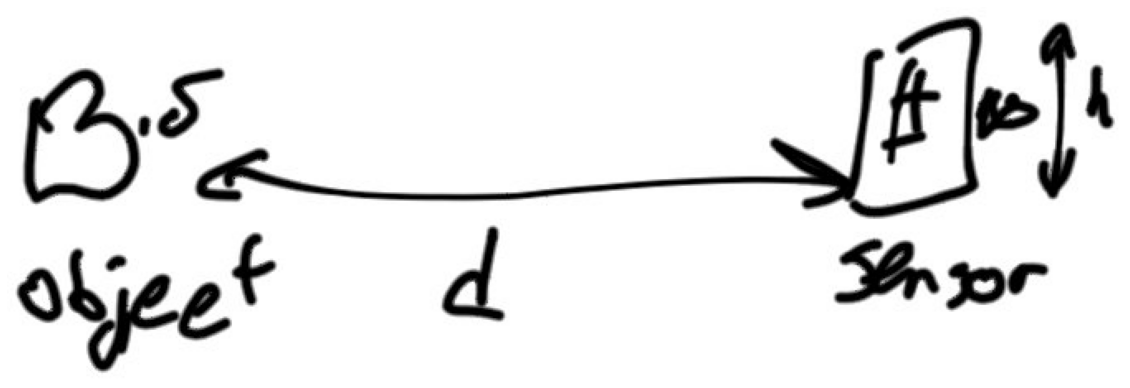

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LDQizYPN6YRJE5SQsNXSQWhADsjUaQba' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1LDQizYPN6YRJE5SQsNXSQWhADsjUaQba" -O system.jpg && rm -rf /tmp/cookies.txt
dog = io.imread('system.jpg')
plt.imshow(dog)
plt.axis(False)


The sensor is of height h with pixel pitch $\Delta $ A ray coming at angle $\theta$ produces fringes with period $\lambda / \sin \theta$, the maximum unaliased incident angle is $\theta = \sin^{-1} \frac{\lambda}{2\Delta}$. The field of view is $2\theta = 2\sin^{-1} \frac{\lambda}{2\Delta}$. The number of resolveable spots on the image is equal to the number of pixels on each dimension $N=\frac{h}{\Delta}$ so the angular ifov is ifov=$\frac{2\theta}{N}=\frac{2\Delta}{h}\sin^{-1} \frac{\lambda}{2\Delta}$. The maximum size of the object is $X=2d \sin\theta= \frac{d\lambda}{\Delta}$, so if for example d is 10 cm, $\Delta=$ 10 microns and $\lambda=$ 1 micron, the maximum size would 1 cm. The ground sample distance, or resolution, on the object will then be $\frac{X}{N}=\frac{d\lambda }{h}$.

## generate training data for defocus imaging

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


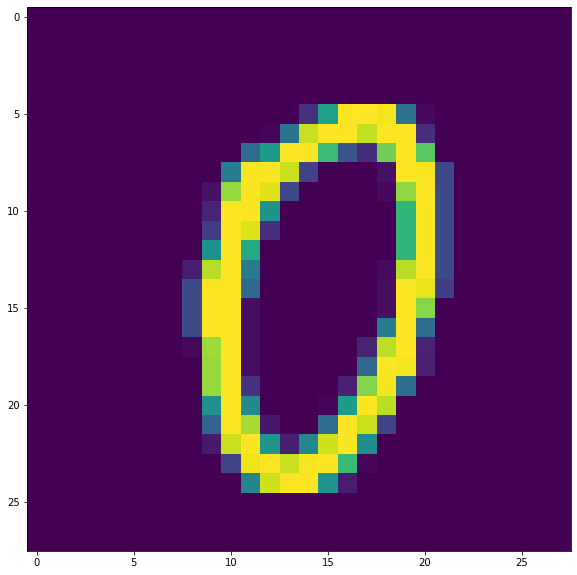

In [ ]:
plt.imshow(train_X[1000,:,:])

## Decoherence operator

We assume that the images are incoherent with coherence length $d$. Given that our test images are 28 by 28, let's say that the test images are 28 by 28 wavelengths across. We upsample them by  interpolation to 56 by 56, so we have about two samples per wavelength. We make them incoherent by multiplying by a random phase, but here the random phase is in 4 by 4 blocks, to the coherence area is about 2 wavelengths. 


In [ ]:
def decoher(x):
  dec=transform.rescale(np.real(x),2)
  mask=np.random.random([14,14])
  mask=transform.rescale(np.real(mask),4)
  dec=np.exp(1j*2*np.pi*mask)*dec
  return dec

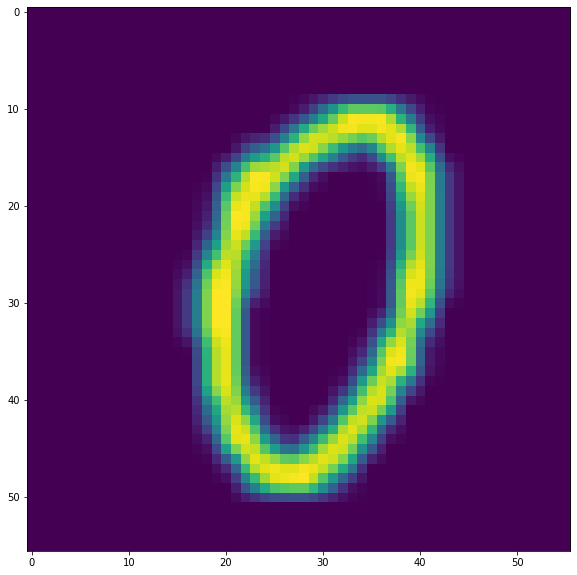

In [ ]:
plt.imshow(np.abs(decoher(train_X[1000,:,:])))

## Defocus Operator

Defocus is multiplication by the phase propagator.

In [ ]:
def defocus(x,l):
  xft=np.zeros([128,128])
  xft[36:92,36:92]=x
  xft=np.fft.fftshift(np.fft.fft2(xft))
  # assume wavlength is 2
  urange=np.linspace(-1./14,1./14,128)
  u,v=np.meshgrid(urange,urange)
  xft=xft*np.exp(1j*2*np.pi*np.sqrt(1./4.-u**2-v**2)*l)
  return np.fft.ifft2(xft)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


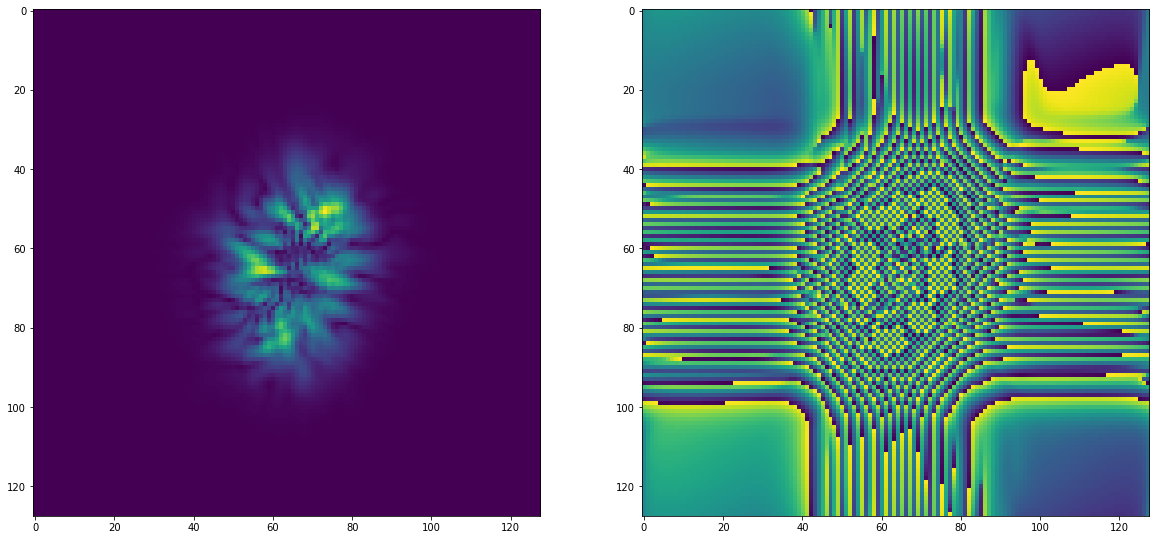

In [ ]:
a=defocus(decoher(train_X[1000,:,:]),1000)
plt.subplot(1,2,1)
plt.imshow(np.abs(a))
plt.subplot(1,2,2)
plt.imshow(np.angle(a))

In [ ]:
(128-56)/2+56

92.0